In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<Axes: xlabel='date'>

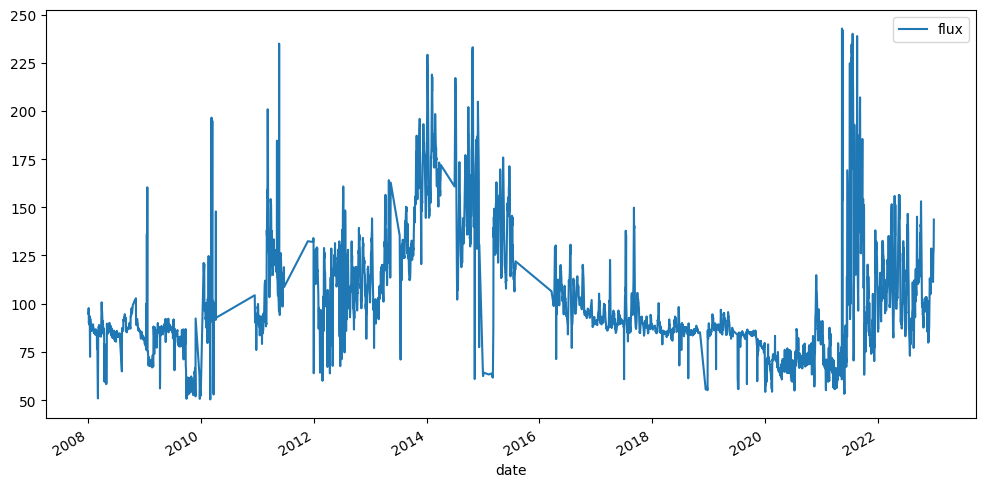

In [177]:
df = pd.read_excel("ai_competition_train.xlsx", index_col="date", parse_dates=True)
df.index.freq='1D'
df = df.dropna(axis=0)
# df = df.interpolate("linear")
df.plot(figsize=(12,6))
# ['linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'barycentric', 'krogh', 'spline', 'polynomial', 'from_derivatives', 'piecewise_polynomial', 'pchip', 'akima', 'cubicspline']

In [178]:
df.head()

,flux
date,
2008-01-01,94.80
2008-01-02,96.93
2008-01-03,97.71
2008-01-04,90.09
2008-01-05,90.74


In [179]:
# from statsmodels.tsa.seasonal import seasonal_decompose

In [180]:
# results = seasonal_decompose(df['flux'])
# results.plot()
# pass

In [181]:
len(df)

4228

In [182]:
train = pd.read_excel("ai_competition_train.xlsx", index_col="date", parse_dates=True)
train = train.dropna(axis=0)
# df = df.interpolate()
test = pd.read_excel("ai_competition_final.xlsx", index_col="date", parse_dates=True)#.drop(["Unnamed: 0"], axis=1)
val = pd.read_excel("answer.xlsx", index_col="date", parse_dates=True)#.drop(["Unnamed: 0"], axis=1)

<Axes: xlabel='date'>

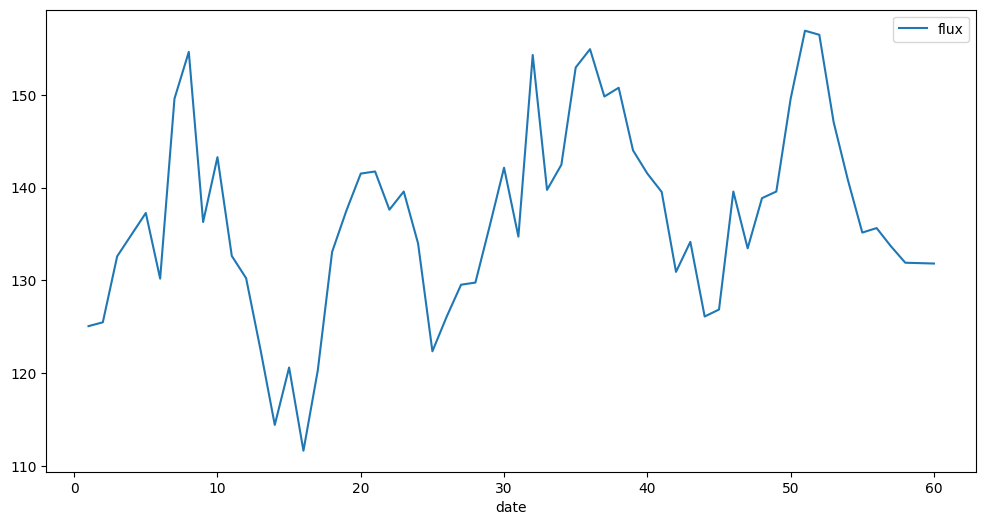

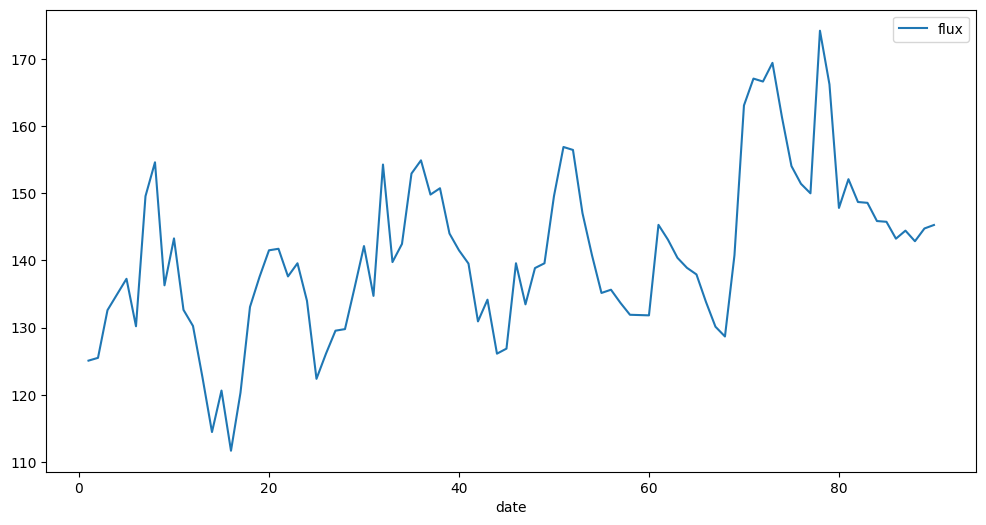

In [183]:
test.plot(figsize=(12,6))
val.plot(figsize=(12,6))

In [184]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# scaler = MinMaxScaler()
scaler = RobustScaler()

In [185]:
train.head(),train.tail(), test.head(),test.tail()

(             flux
 date             
 2008-01-01  94.80
 2008-01-02  96.93
 2008-01-03  97.71
 2008-01-04  90.09
 2008-01-05  90.74,
                flux
 date               
 2022-12-26  111.241
 2022-12-27  120.425
 2022-12-28  125.205
 2022-12-30  128.634
 2022-12-31  143.651,
           flux
 date          
 1     125.0810
 2     125.4960
 3     132.6010
 4     134.9365
 5     137.2720,
          flux
 date         
 56    135.644
 57    133.682
 58    131.912
 59    131.869
 60    131.826)

In [186]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_val = scaler.transform(val)
use_scaler = True

# scaled_train = train["flux"].to_numpy().reshape(-1, 1)
# scaled_test = test["flux"].to_numpy().reshape(-1, 1)
# scaled_val = val["flux"].to_numpy().reshape(-1, 1)

In [187]:
print(np.max(scaled_train))

5.007205565678318


In [188]:
# print(scaler.transform(train)[:10].shape)
# type(scaler.transform(train))

In [189]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten
from keras.layers import LSTM, Conv1D
import tensorflow as tf

In [190]:
# We do the same thing, but now instead for 12 months
n_features = 1

n_input = 60
batch_size = 128
layer_size = 128

epochs = 100

generator_train = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=batch_size)

validation = True
if validation:
    generator_val = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

# define model
def create_model():
    activation = "elu"
    tf.keras.backend.clear_session()
    cmodel = Sequential()
    cmodel.add(Conv1D(filters=64,
                       kernel_size=5,
                       strides=1,
                       padding="causal",
                       activation=activation,
                       input_shape=(n_input, n_features)))
    cmodel.add(MaxPooling1D(pool_size=2, strides=3, padding="valid"))
    cmodel.add(Conv1D(filters=32, kernel_size=2, strides=1, padding="causal", activation=activation))
    cmodel.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
    cmodel.add(LSTM(layer_size, activation=activation, return_sequences=True))
    cmodel.add(LSTM(layer_size, activation=activation, return_sequences=True))
    cmodel.add(Flatten())
    cmodel.add(Dense(128, activation=activation))
    cmodel.add(Dropout(0.2))
    cmodel.add(Dense(32, activation=activation))
    cmodel.add(Dropout(0.1))
    cmodel.add(Dense(1))
    cmodel.compile(optimizer='adam', loss='mse')

    # cmodel.add(LSTM(60, activation='relu', return_sequences=True))
    # cmodel.add(Dropout(0.2))
    # cmodel.add(LSTM(30, activation='relu'))
    # cmodel.add(Dense(1))
    # cmodel.compile(optimizer='adam', loss='mse')

    return cmodel

model = create_model()

In [191]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 60, 64)            384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 32)            4128      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 19, 32)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 19, 128)           82432     
                                                                 
 lstm_1 (LSTM)               (None, 19, 128)           1

In [192]:
# Include the epoch in the file name (uses `str.format`)
import os
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

checkpoint_path = f"weights/cp_i{n_input}_b{batch_size}_l{layer_size}_e{epochs}_t{current_time[:5]}"
if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)

checkpoint_dir = "/home/tidy/PycharmProjects/space_sun/" + checkpoint_path

if validation:
    checkpoint_path = checkpoint_path + "/cp-{epoch:04d}-{loss:04f}.ckpt"
else:
    checkpoint_path = checkpoint_path + "/cp-{epoch:04d}-{loss:04f}.ckpt"

# Calculate the number of batches per epoch
import math
n_batches = train.shape[0] / batch_size
n_batches = math.ceil(n_batches)    # round up the number of batches to the nearest whole integer
print(n_batches)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    # save_best_only=True,
    save_freq=5*33,
    save_weights_only=True,
    verbose=1,)

# fit model
# latest = tf.train.latest_checkpoint("/home/tidy/PycharmProjects/space_sun/weights/cp_i60_b64_l128_e1000_t18:46")
# print(latest)
# model.load_weights(latest)
if validation:
    model.fit(generator_train, epochs=epochs, callbacks=[cp_callback], validation_data=generator_val, validation_batch_size=1)
else:
    model.fit(generator_train, epochs=epochs, callbacks=[cp_callback])

Current Time = 22:07:59
34
Epoch 1/100
33/33 [==============================] - 4s 58ms/step - loss: 0.6029 - val_loss: 2.2331
Epoch 2/100
33/33 [==============================] - 2s 50ms/step - loss: 0.5378 - val_loss: 0.9011
Epoch 3/100
33/33 [==============================] - 2s 50ms/step - loss: 0.5116 - val_loss: 0.2352
Epoch 4/100
33/33 [==============================] - 2s 53ms/step - loss: 0.5929 - val_loss: 0.8508
Epoch 5/100
32/33 [============================>.] - ETA: 0s - loss: 0.4739
Epoch 5: saving model to weights/cp_i60_b128_l128_e100_t22:07/cp-0005-0.470332.ckpt
33/33 [==============================] - 2s 53ms/step - loss: 0.4703 - val_loss: 0.2495
Epoch 6/100
33/33 [==============================] - 2s 53ms/step - loss: 0.5067 - val_loss: 0.4786
Epoch 7/100
33/33 [==============================] - 2s 50ms/step - loss: 0.4517 - val_loss: 1.9414
Epoch 8/100
33/33 [==============================] - 2s 52ms/step - loss: 0.6356 - val_loss: 1.8131
Epoch 9/100
33/33 [======

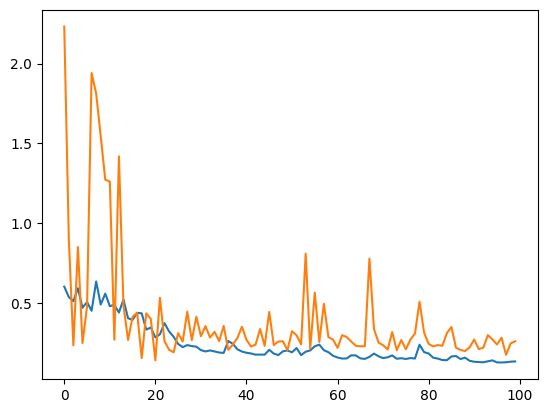

In [193]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
if validation:
    val_loss_per_epoch = model.history.history['val_loss']
    plt.plot(range(len(val_loss_per_epoch)), val_loss_per_epoch)

In [194]:
# last_train_batch = scaled_test[:30]
# last_train_batch = last_train_batch.reshape((1, n_input, n_features))
# model.predict(last_train_batch)
# scaled_test[0]

In [195]:
test_predictions = []


first_eval_batch = scaled_test[-n_input:]

current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(30):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# test_predictions = []
#
# first_eval_batch = scaled_test[n_input:]
# current_batch = first_eval_batch.reshape((1, n_input, n_features))
# test_predictions = model.predict(current_batch)[0]

1/1 [==============================] - 0s 21ms/step


In [196]:
ans = pd.read_excel("ai_competition_templet_date.xlsx", index_col="date", parse_dates=True)
# np.array(test_data["flux"])[0]
# ans['date'] = pd.date_range(start='2023/03/01', periods=len(ans), freq='D')
# ans["flux"] = test_predictions
# ans.to_excel("ai_competition_templet_date.xlsx", index=None)

if use_scaler:
    true_predictions = scaler.inverse_transform(test_predictions)
    ans['flux'] = [x[0] for x in true_predictions]
else:
    ans['flux'] = ans['flux'] = [x[0] for x in test_predictions]
ans.to_excel(f"ans_i{n_input}_b{batch_size}_l{layer_size}_e{epochs}.xlsx")
ans

,flux
date,
2023-03-01,128.436525
2023-03-02,129.215096
2023-03-03,131.080594
2023-03-04,131.122853
2023-03-05,132.976361
2023-03-06,134.008003
2023-03-07,135.806032
2023-03-08,139.529932
2023-03-09,138.847293


<Axes: xlabel='date'>

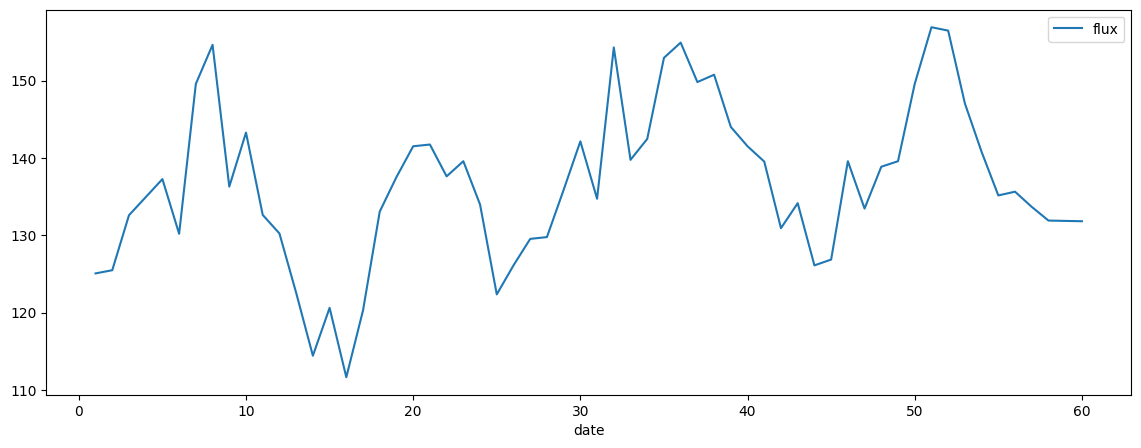

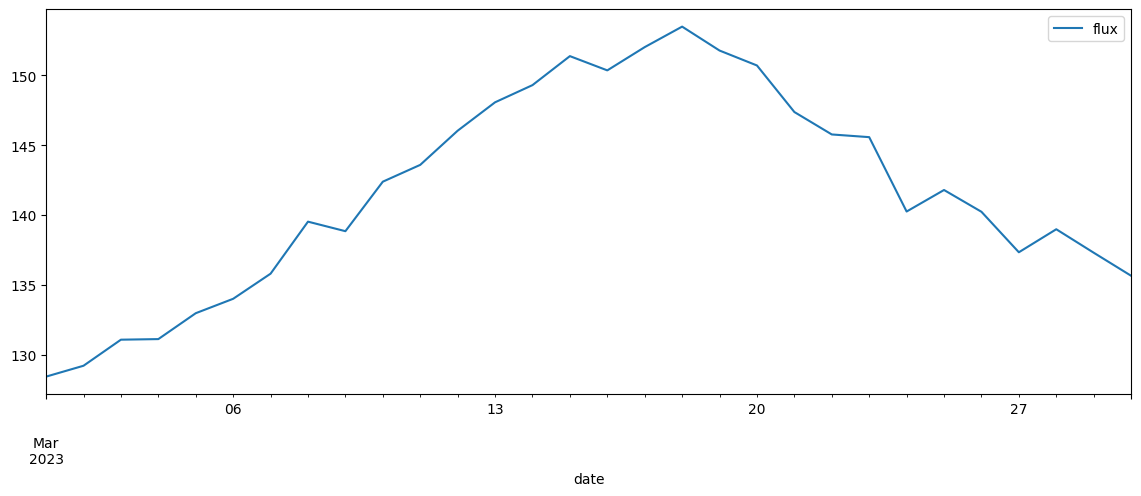

In [197]:
test.plot(figsize=(14,5))
ans.plot(figsize=(14,5))

In [198]:
# ans = pd.read_excel("ai_competition_templet.xlsx", index_col="date", parse_dates=True)
# s = test_predictions[-30:]
# ans["flux"] = test_predictions[-30:]
# ans.to_excel("lstm_60_50.xlsx")
# ans

In [199]:
# tf.keras.backend.clear_session()
# test_model = create_model()
#
# print(checkpoint_dir)
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# print(latest)
# test_model.load_weights(latest)
# # new_model = tf.keras.models.load_model("/home/tidy/PycharmProjects/space_sun/weights/cp_i60_b32_l32_e1000_t21:23/cp-0739-117.763603.ckpt")
# test_predictions = []
#
# first_eval_batch = scaled_test[-n_input:]
# current_batch = first_eval_batch.reshape((1, n_input, n_features))
#
# for i in range(30):
#
#     # get the prediction value for the first batch
#     current_pred = test_model.predict(current_batch)[0]
#
#     # append the prediction into the array
#     test_predictions.append(current_pred)
#
#     # use the prediction to update the batch and remove the first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
# # test_predictions = model.predict(current_batch)[0]
#
# test.plot(figsize=(14,5))
#
#
# ans = pd.read_excel("ai_competition_templet_date.xlsx", index_col="date", parse_dates=True)
# # true_predictions = scaler.inverse_transform(test_predictions)
# # ans['flux'] = [x[0] for x in test_predictions]
# ans['flux'] = test_predictions
# ans.to_excel(f"ans_i{n_input}_b{batch_size}_l{layer_size}_e{epochs}.xlsx")
# ans.plot(figsize=(14,5))

In [202]:
checkpoint_dir = "/home/tidy/PycharmProjects/space_sun/weights/cp_i60_b1_l128_e200_t23:01"
ckpt_list = os.listdir(checkpoint_dir)
print(ckpt_list)
ckpt_files = []
for c in ckpt_list:
    if "index" in c.split('.'):
        ckpt_files.append(c[:-6])

ckpt_files = np.sort(ckpt_files)
print(ckpt_files)

['cp-0039-0.038791.ckpt.index', 'cp-0001-0.640696.ckpt.data-00000-of-00001', 'cp-0005-0.136281.ckpt.index', 'cp-0051-0.023643.ckpt.data-00000-of-00001', 'cp-0008-0.132113.ckpt.data-00000-of-00001', 'cp-0072-0.011313.ckpt.index', 'cp-0098-0.006769.ckpt.data-00000-of-00001', 'cp-0096-0.010605.ckpt.data-00000-of-00001', 'cp-0142-0.004959.ckpt.index', 'cp-0051-0.023643.ckpt.index', 'cp-0058-0.015955.ckpt.index', 'cp-0055-0.023257.ckpt.index', 'cp-0028-0.049760.ckpt.data-00000-of-00001', 'cp-0045-0.036648.ckpt.index', 'cp-0089-0.011092.ckpt.data-00000-of-00001', 'cp-0072-0.011313.ckpt.data-00000-of-00001', 'cp-0020-0.078091.ckpt.data-00000-of-00001', 'cp-0012-0.096434.ckpt.index', 'cp-0142-0.004959.ckpt.data-00000-of-00001', 'cp-0008-0.132113.ckpt.index', 'cp-0045-0.036648.ckpt.data-00000-of-00001', 'cp-0046-0.033040.ckpt.data-00000-of-00001', 'cp-0015-0.095721.ckpt.data-00000-of-00001', 'cp-0009-0.124941.ckpt.index', 'cp-0002-0.222902.ckpt.data-00000-of-00001', 'cp-0002-0.222902.ckpt.index

/home/tidy/PycharmProjects/space_sun/weights/cp_i60_b1_l128_e200_t23:01
['cp-0001-0.640696.ckpt' 'cp-0002-0.222902.ckpt' 'cp-0003-0.192442.ckpt'
 'cp-0004-0.183433.ckpt' 'cp-0005-0.136281.ckpt' 'cp-0007-0.132642.ckpt'
 'cp-0008-0.132113.ckpt' 'cp-0009-0.124941.ckpt' 'cp-0012-0.096434.ckpt'
 'cp-0015-0.095721.ckpt' 'cp-0020-0.078091.ckpt' 'cp-0022-0.060100.ckpt'
 'cp-0026-0.052726.ckpt' 'cp-0028-0.049760.ckpt' 'cp-0029-0.048091.ckpt'
 'cp-0031-0.048083.ckpt' 'cp-0037-0.041566.ckpt' 'cp-0039-0.038791.ckpt'
 'cp-0045-0.036648.ckpt' 'cp-0046-0.033040.ckpt' 'cp-0048-0.024968.ckpt'
 'cp-0051-0.023643.ckpt' 'cp-0055-0.023257.ckpt' 'cp-0058-0.015955.ckpt'
 'cp-0069-0.014011.ckpt' 'cp-0072-0.011313.ckpt' 'cp-0089-0.011092.ckpt'
 'cp-0096-0.010605.ckpt' 'cp-0098-0.006769.ckpt' 'cp-0119-0.006510.ckpt'
 'cp-0142-0.004959.ckpt' 'cp-0153-0.003841.ckpt']
1/1 [==============================] - 0s 19ms/step
cp-0001-0.640696.ckpt
1/1 [==============================] - 0s 20ms/step
cp-0002-0.222902.ckpt


/home/tidy/PycharmProjects/space_sun/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


1/1 [==============================] - 0s 18ms/step
cp-0051-0.023643.ckpt
1/1 [==============================] - 0s 20ms/step
cp-0055-0.023257.ckpt
1/1 [==============================] - 0s 19ms/step
cp-0058-0.015955.ckpt
1/1 [==============================] - 0s 18ms/step
cp-0069-0.014011.ckpt
1/1 [==============================] - 0s 18ms/step
cp-0072-0.011313.ckpt
1/1 [==============================] - 0s 19ms/step
cp-0089-0.011092.ckpt
1/1 [==============================] - 0s 18ms/step
cp-0096-0.010605.ckpt
1/1 [==============================] - 0s 19ms/step
cp-0098-0.006769.ckpt
1/1 [==============================] - 0s 19ms/step
cp-0119-0.006510.ckpt
1/1 [==============================] - 0s 19ms/step
cp-0142-0.004959.ckpt
1/1 [==============================] - 0s 16ms/step
cp-0153-0.003841.ckpt


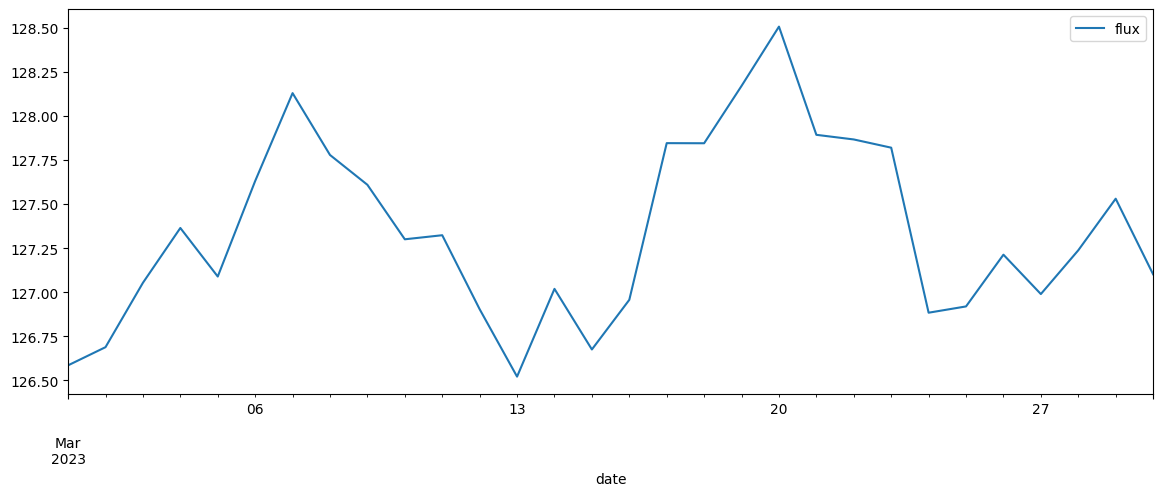

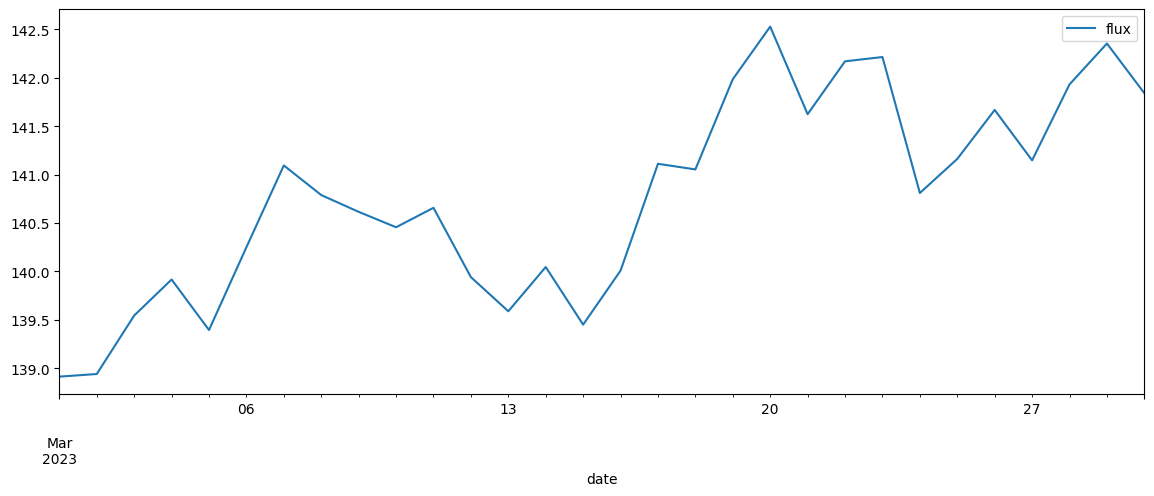

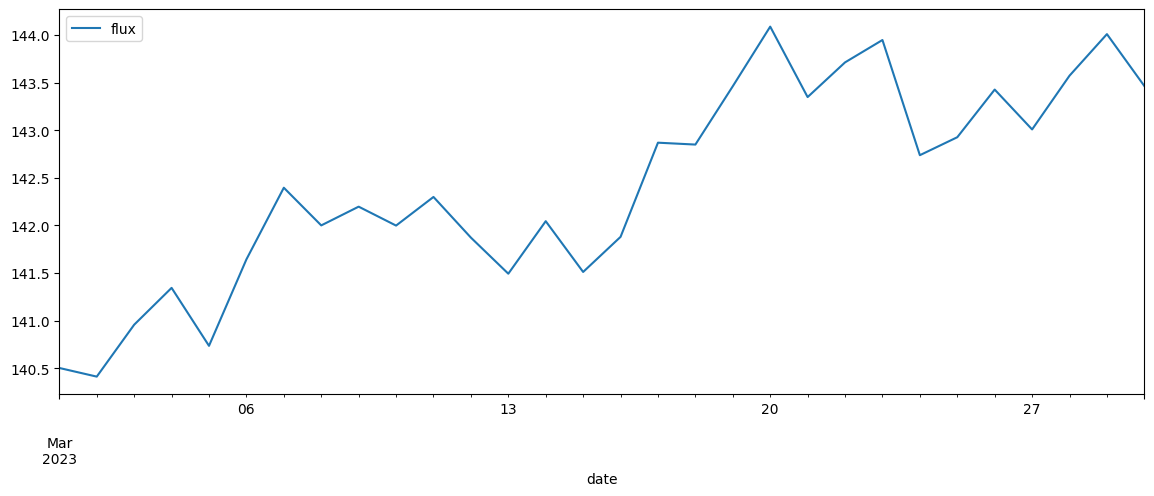

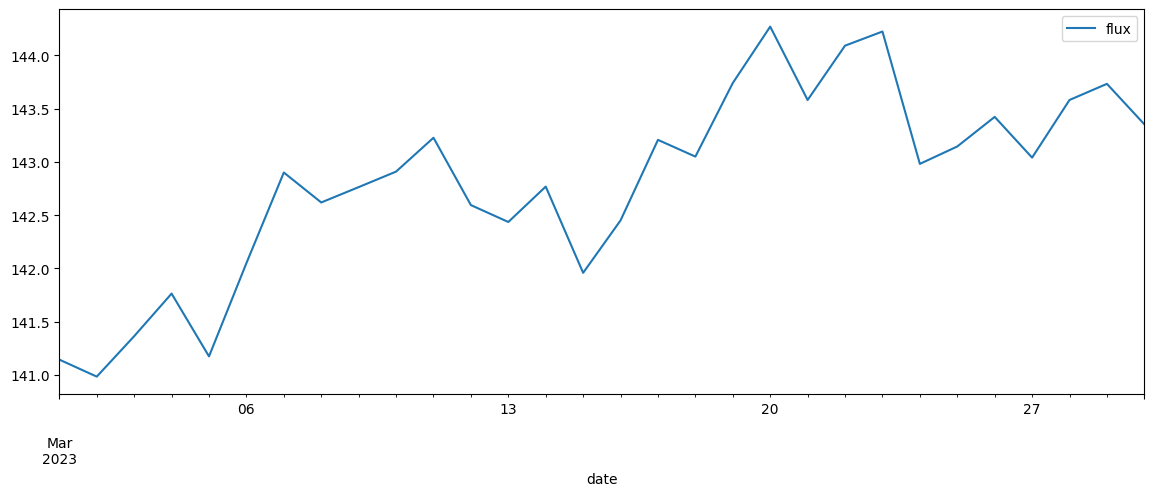

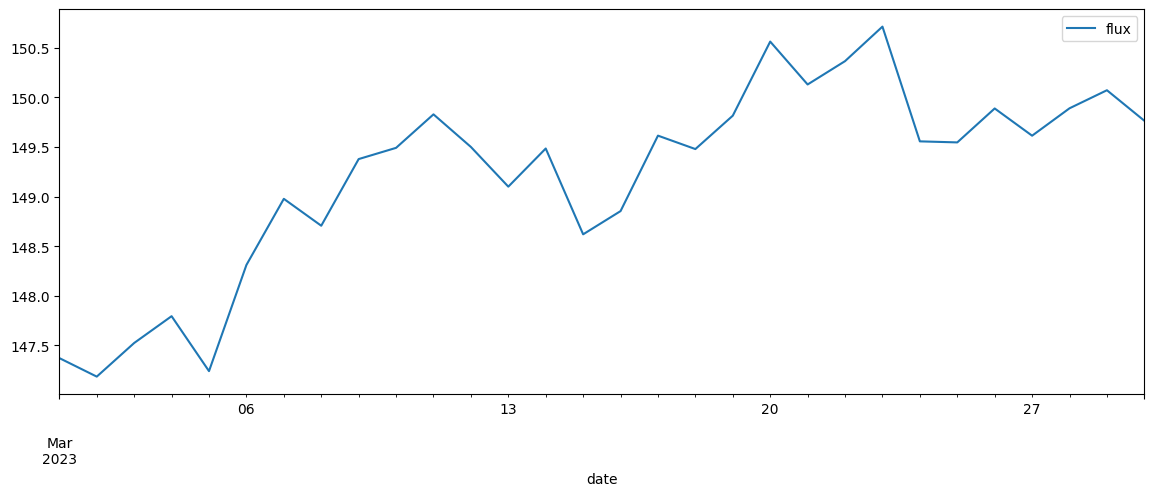

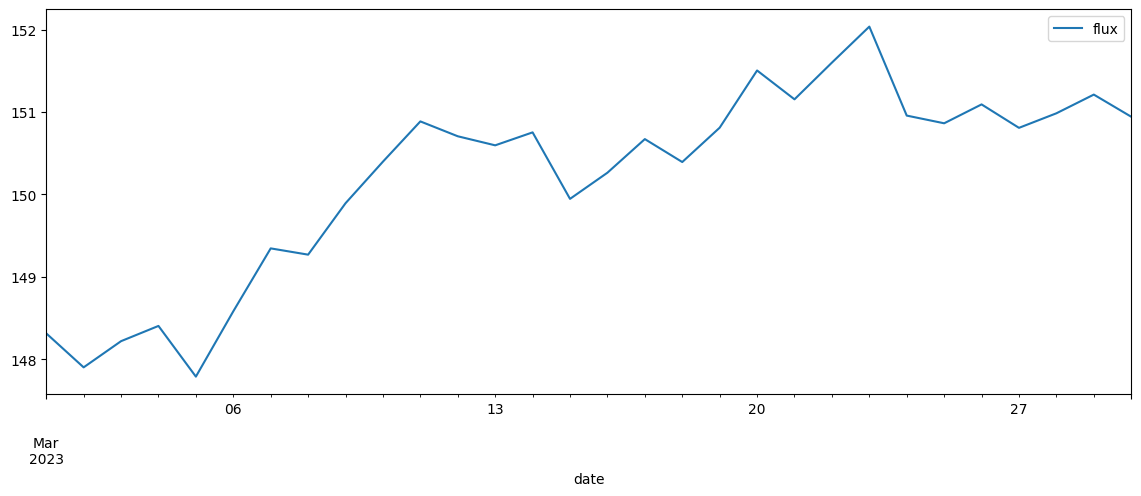

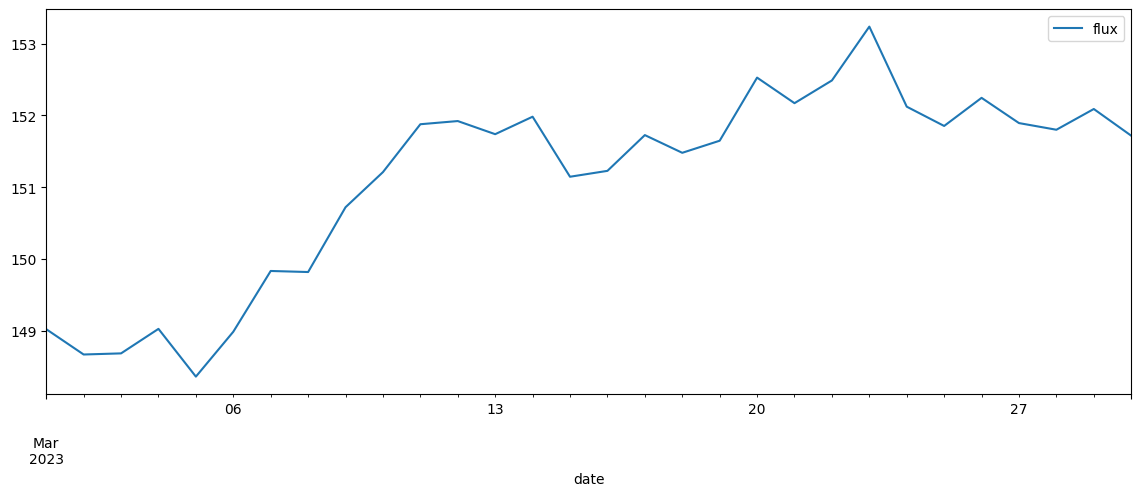

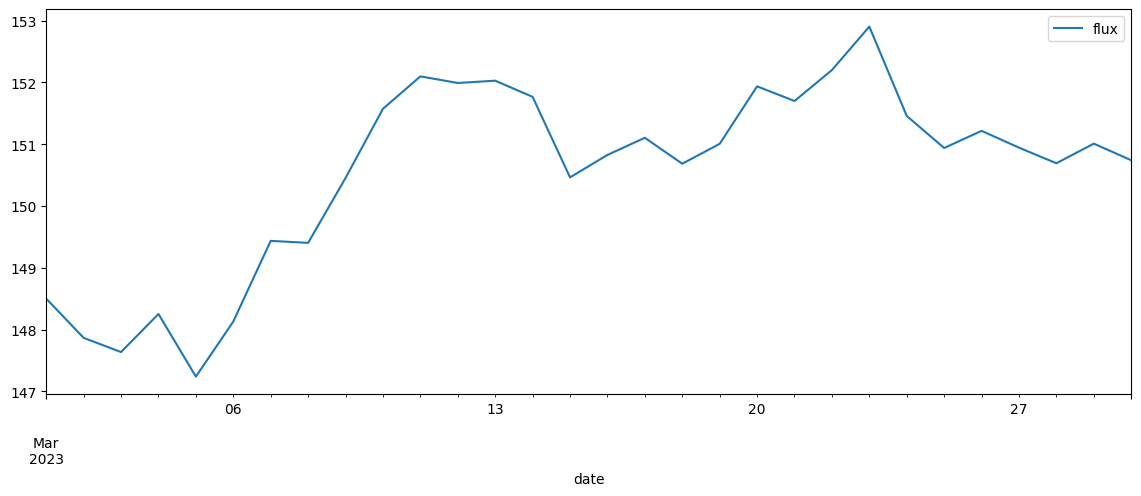

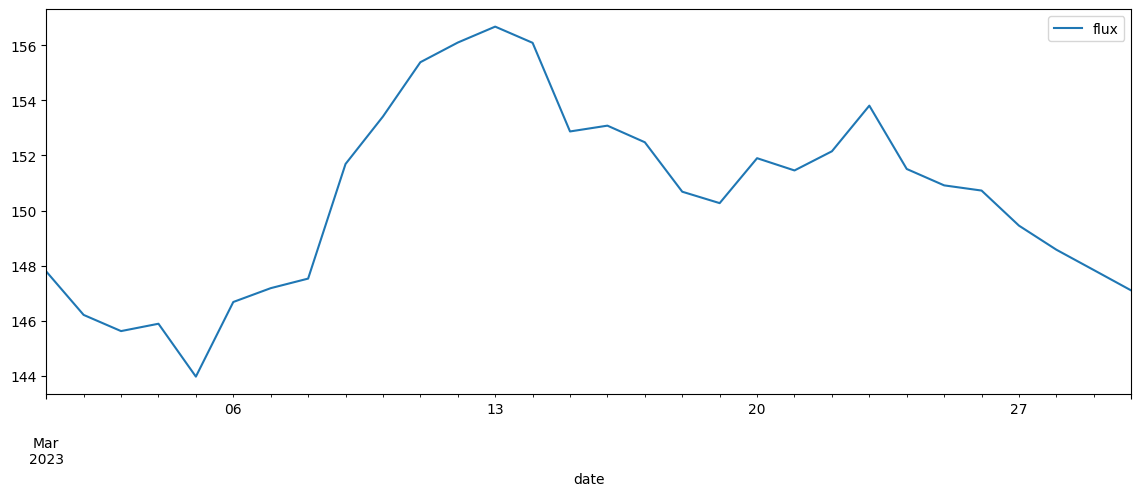

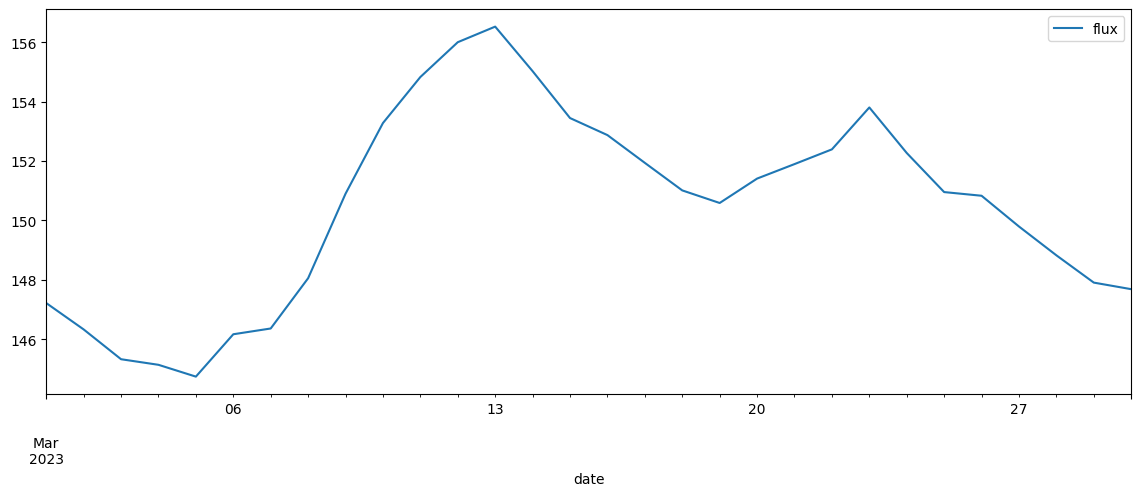

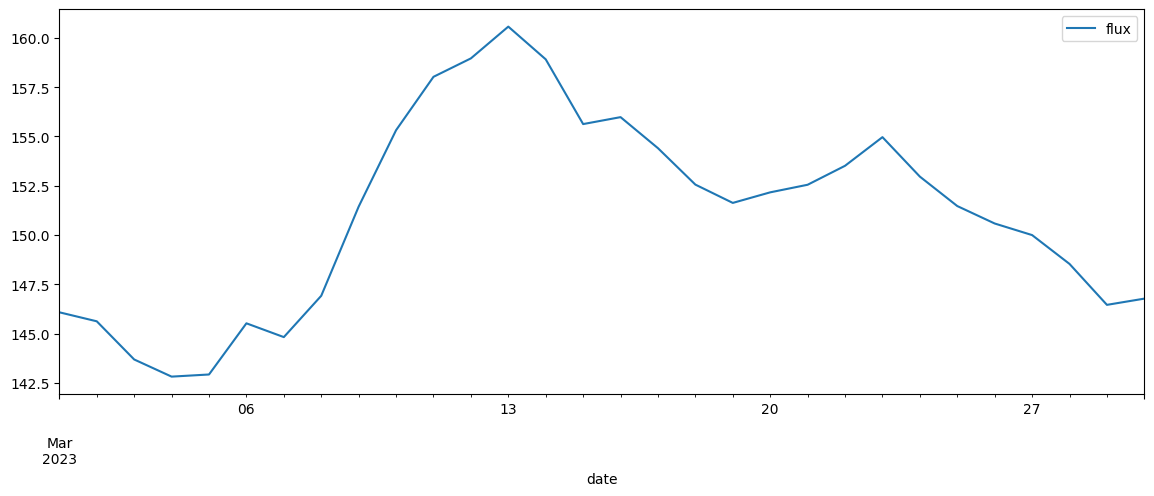

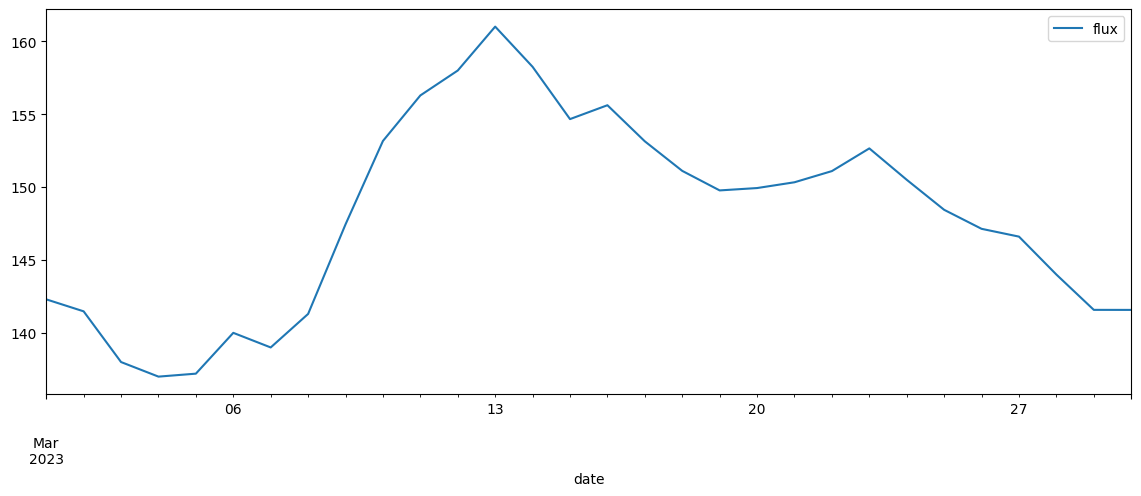

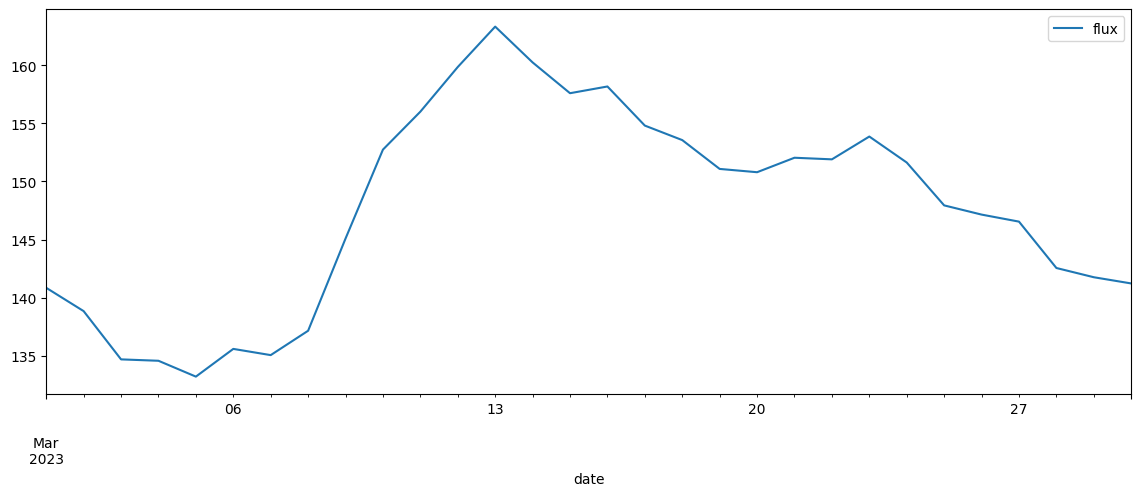

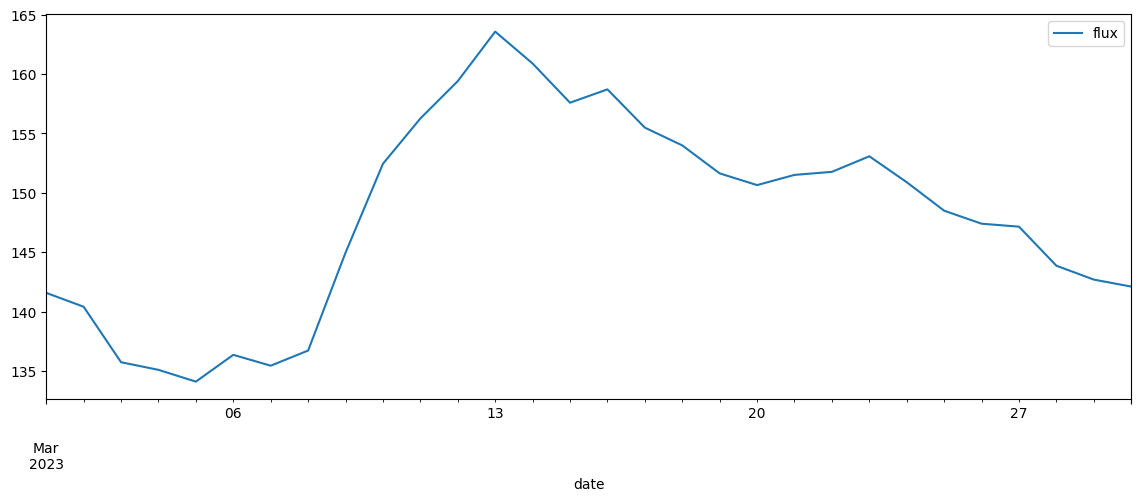

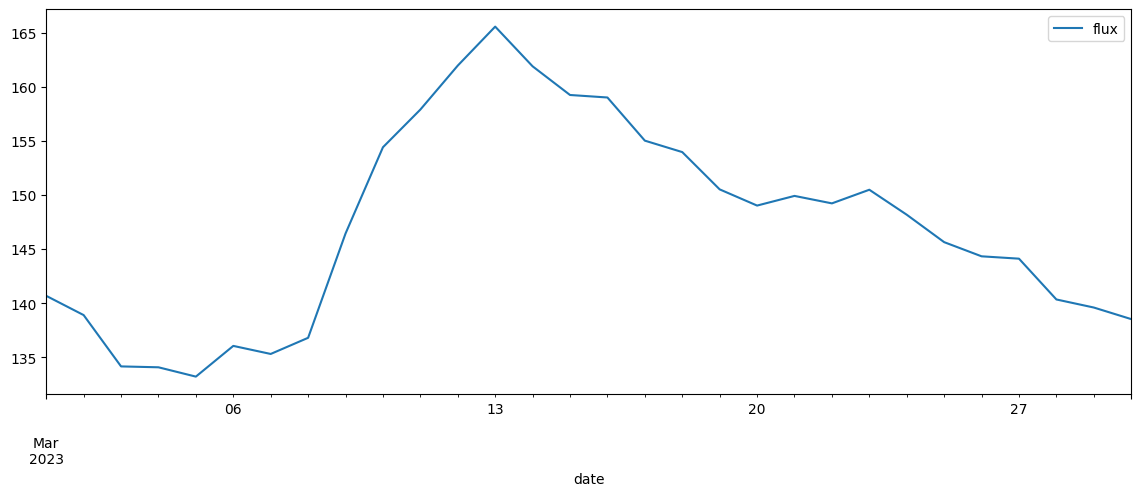

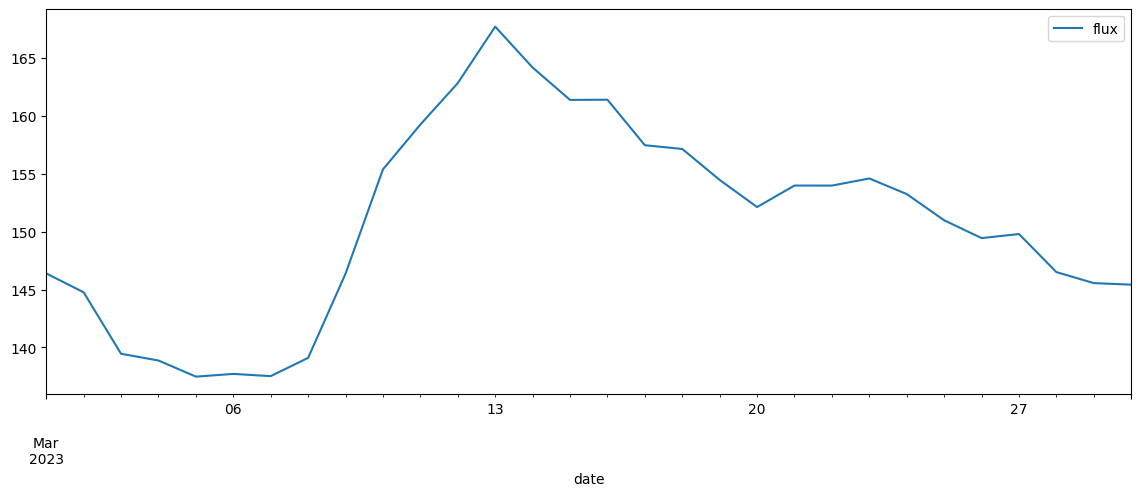

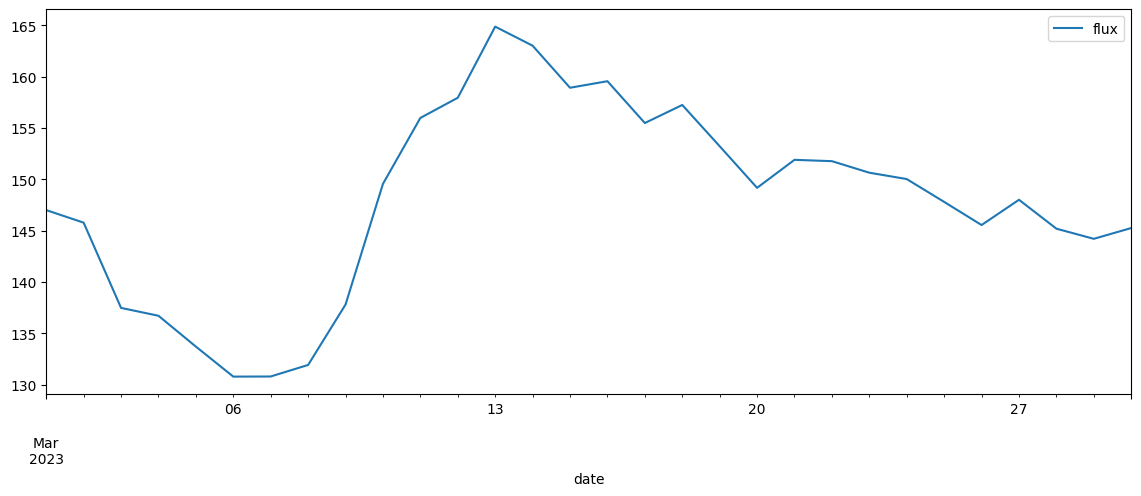

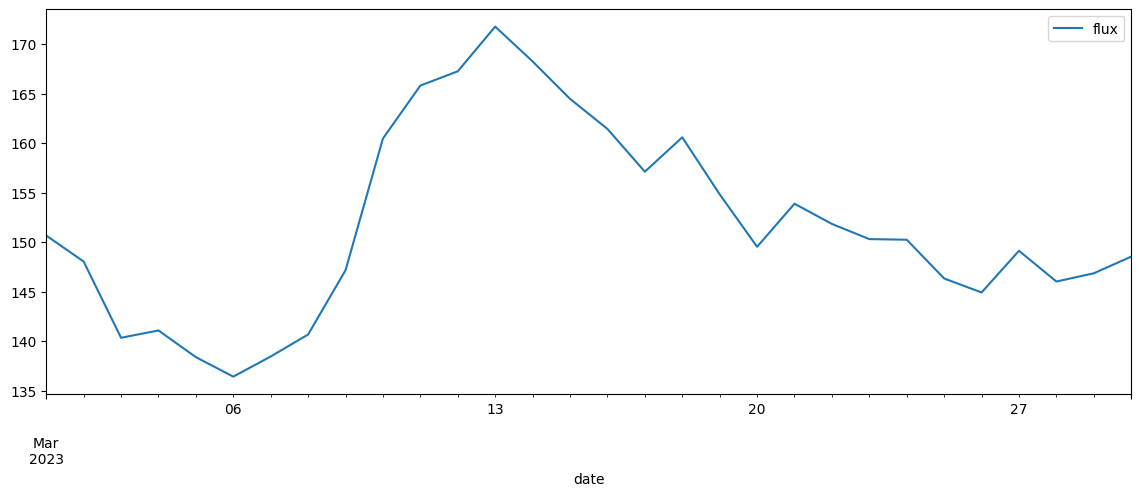

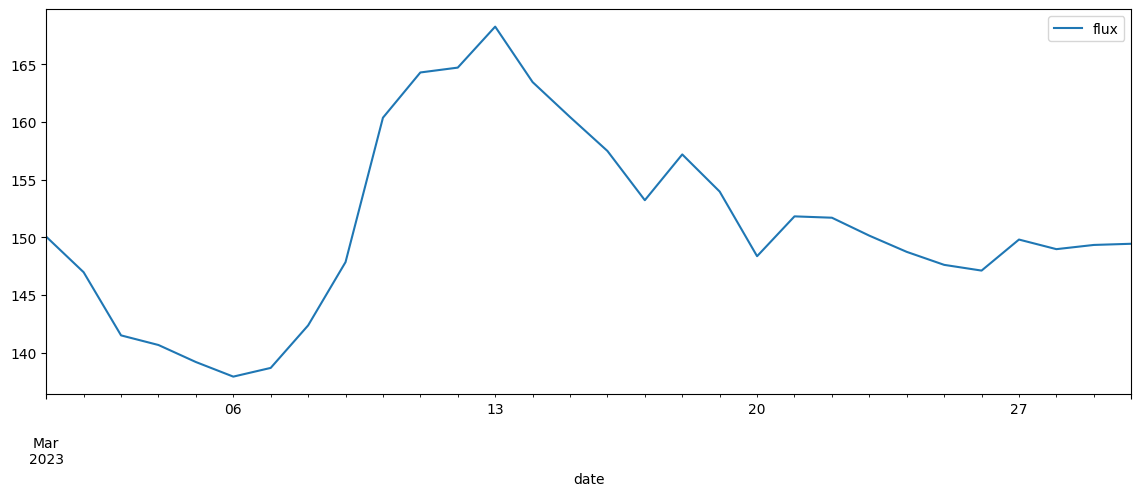

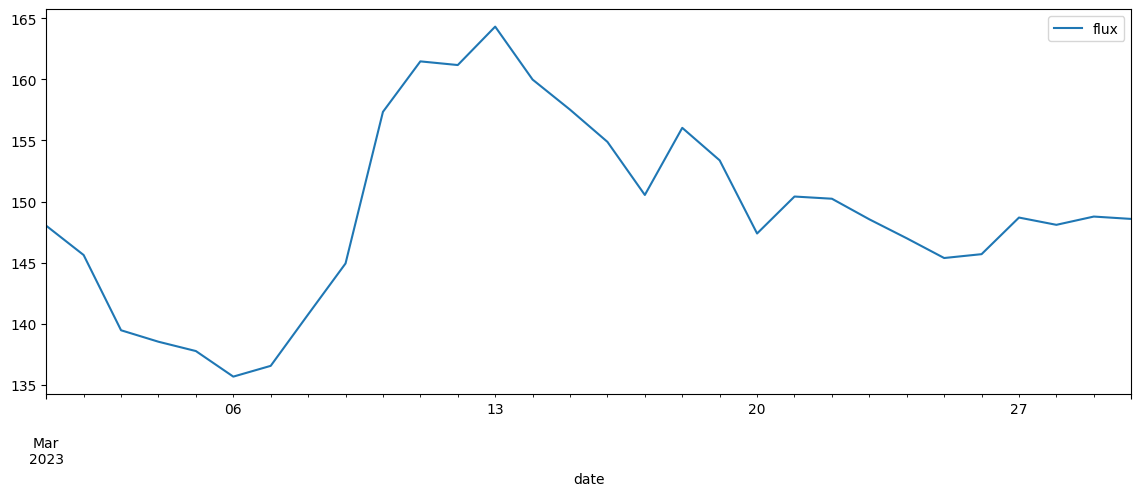

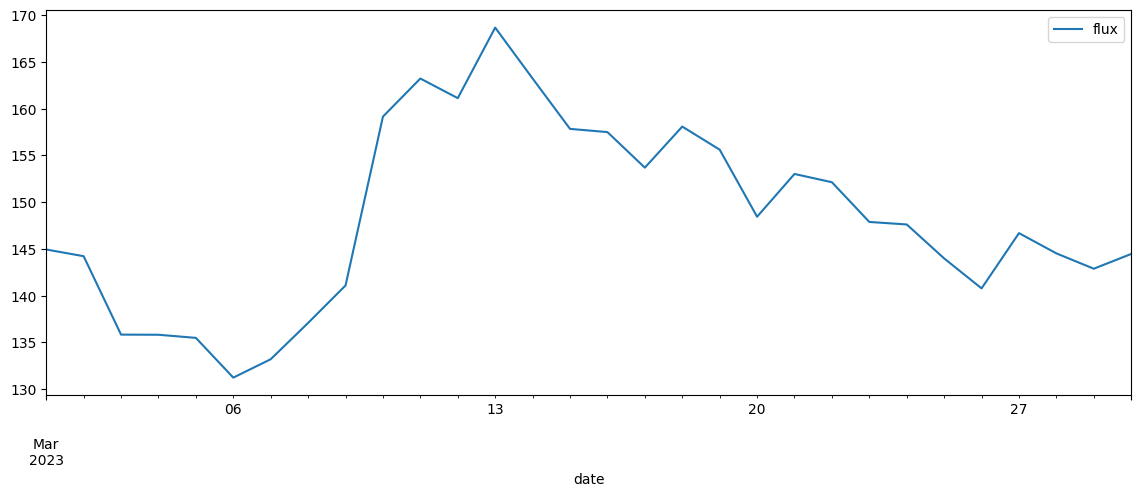

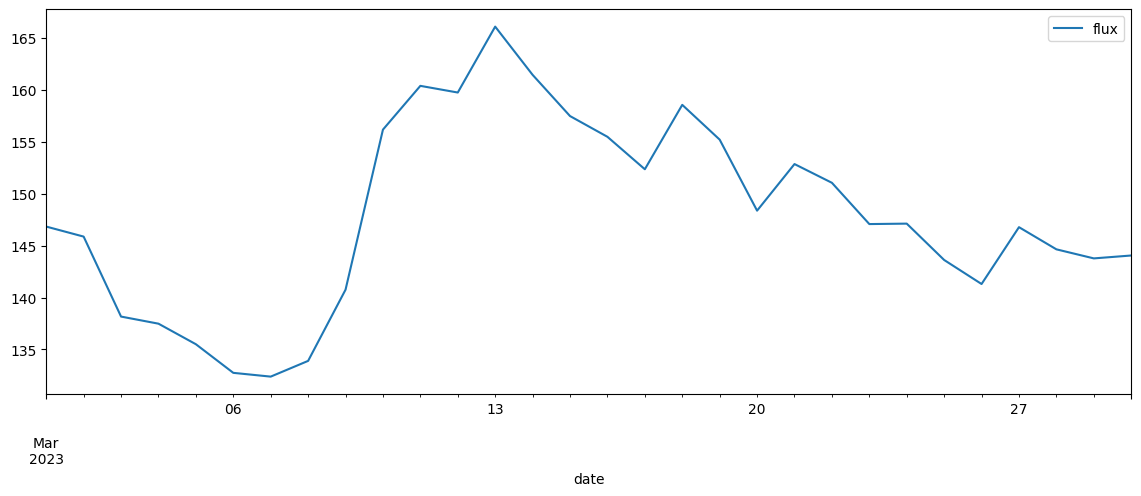

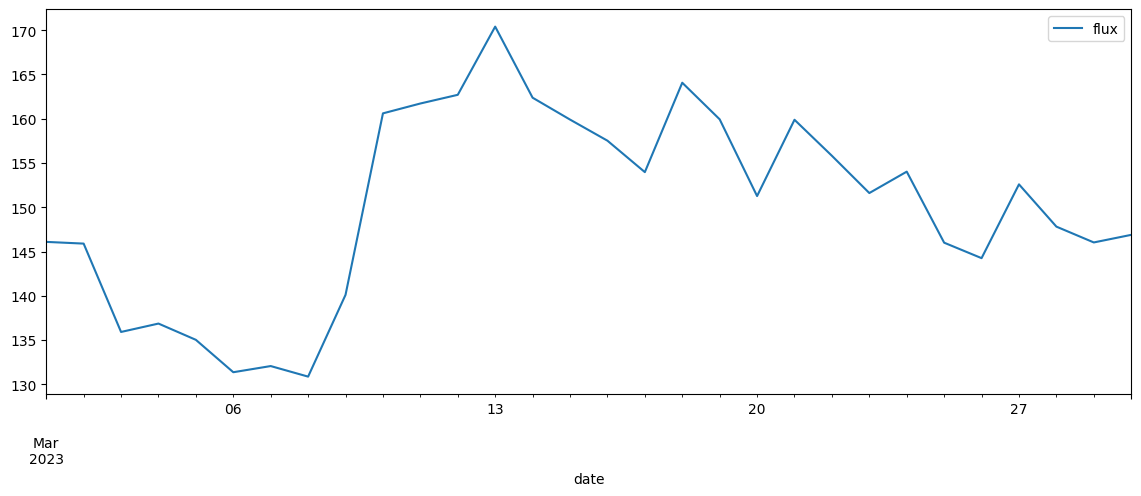

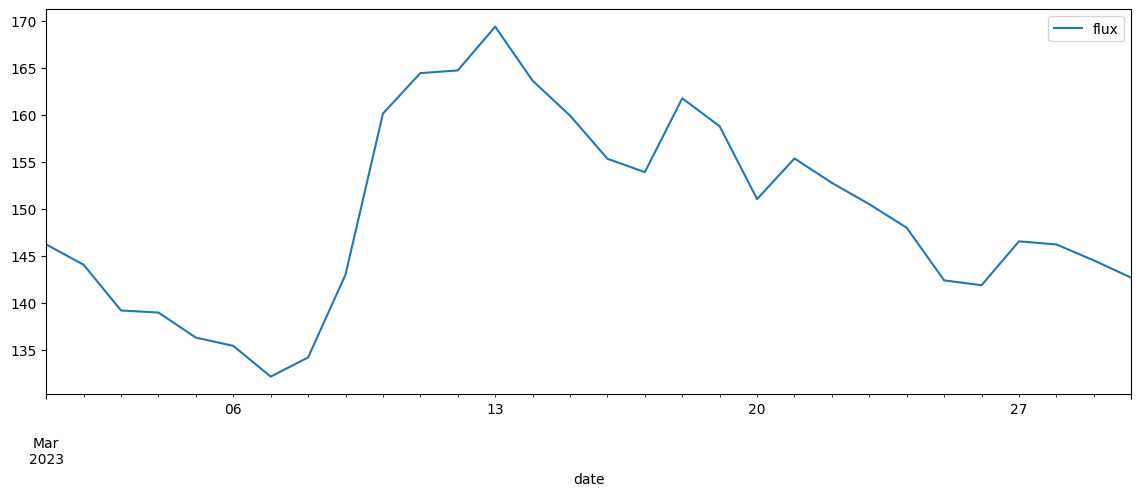

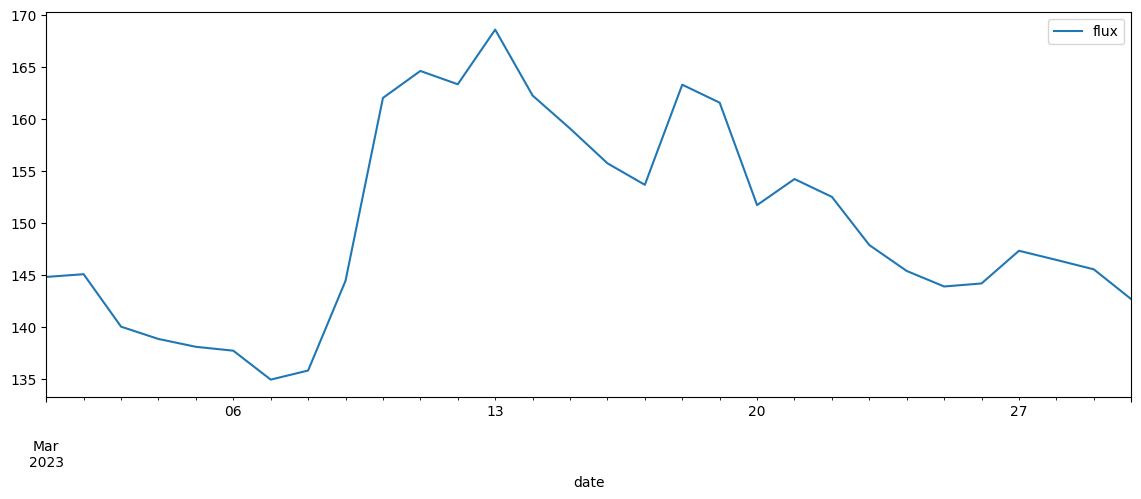

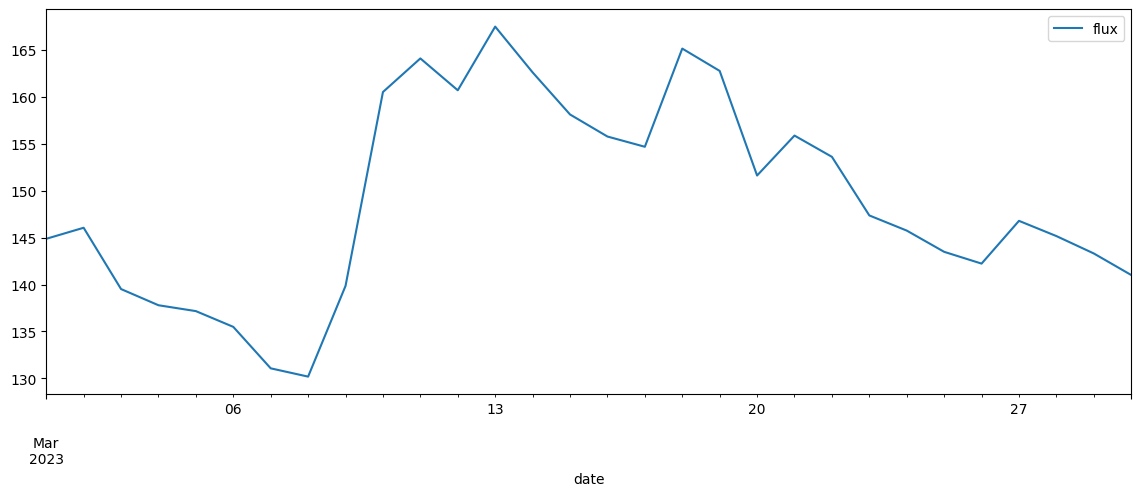

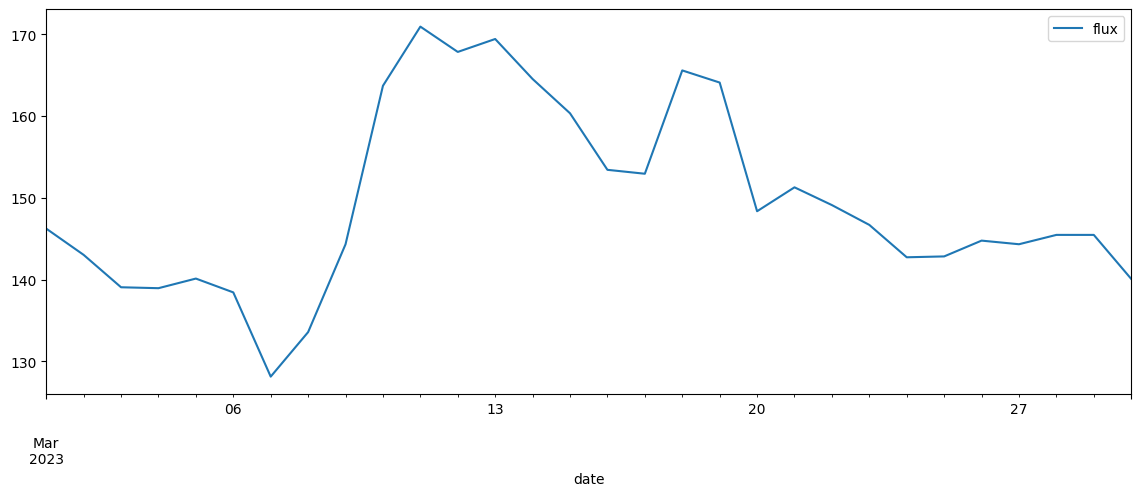

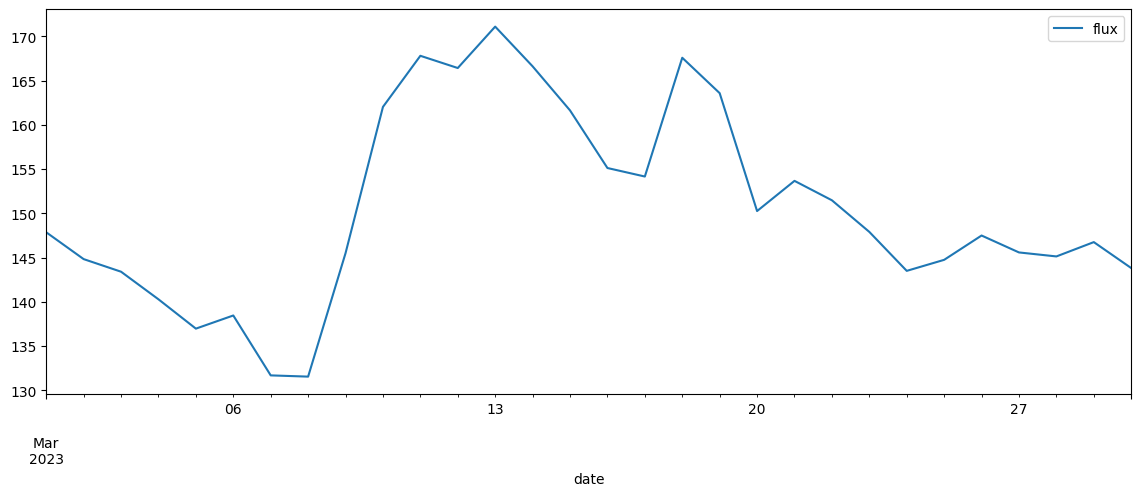

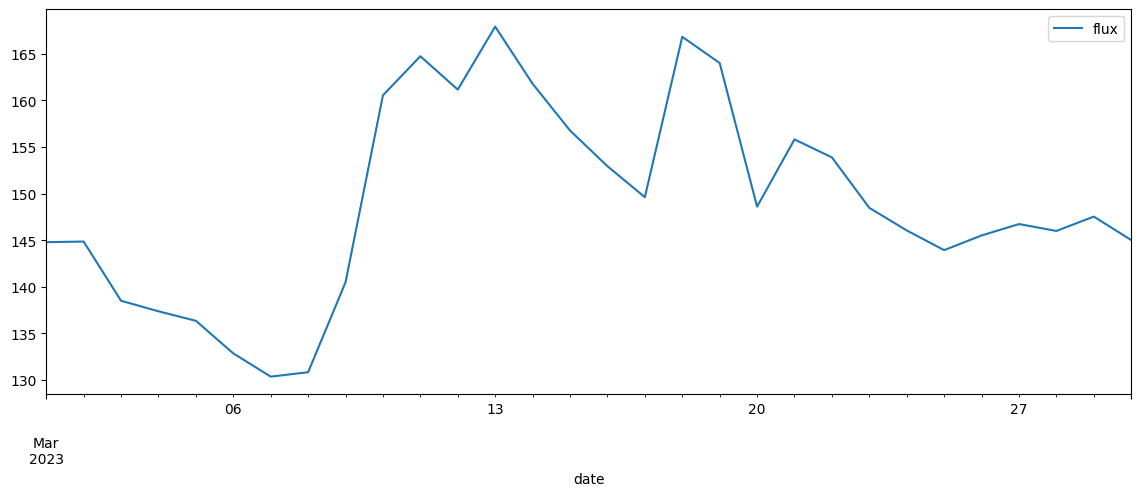

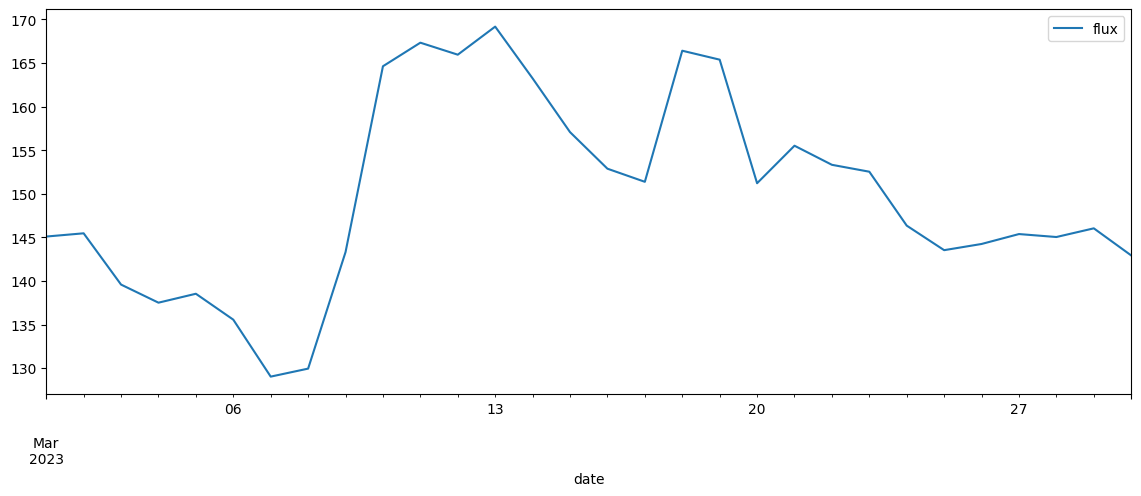

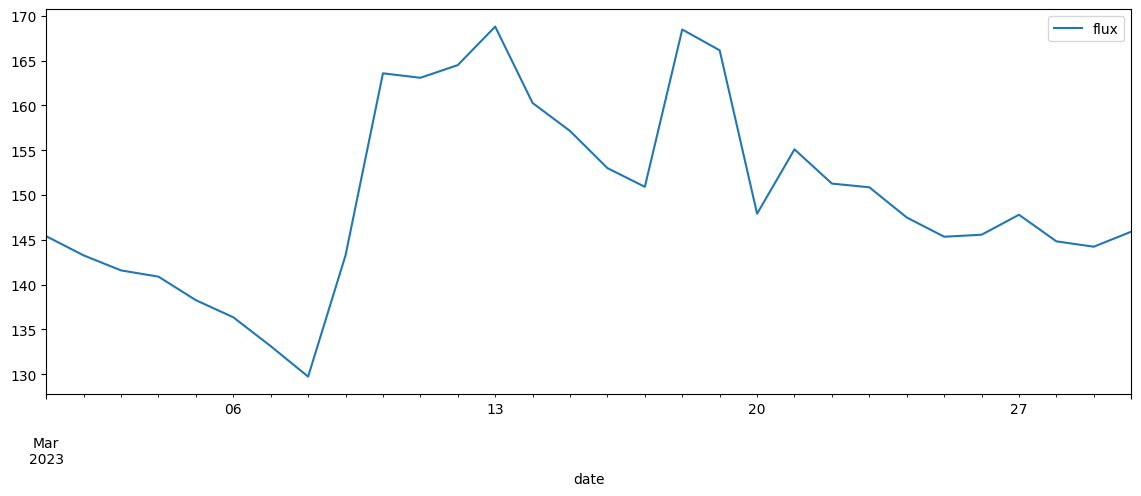

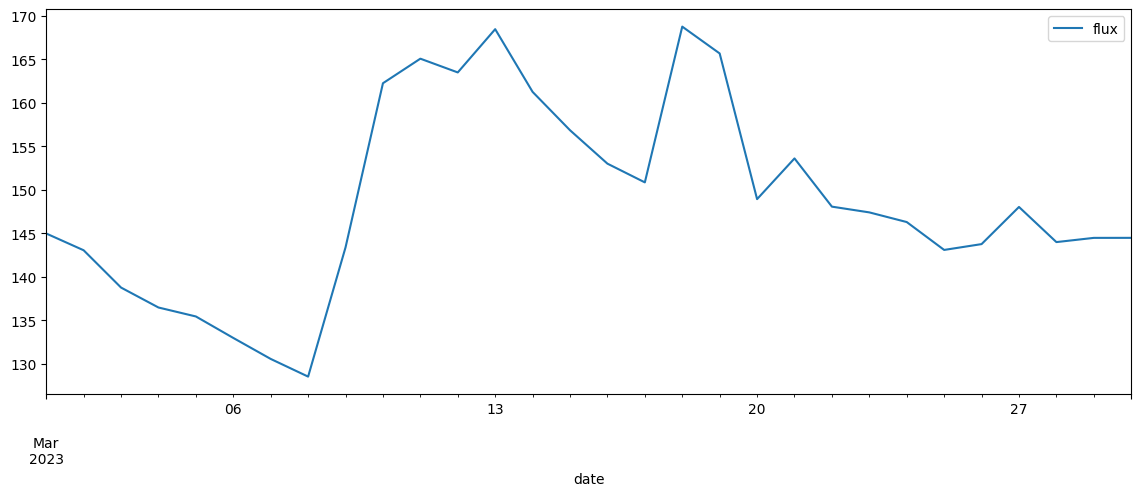

In [203]:
print(checkpoint_dir)
print(ckpt_files)
for w in ckpt_files:
    ans_model = create_model()
    ans_model.load_weights(checkpoint_dir + '/' + w)
    # new_model = tf.keras.models.load_model("/home/tidy/PycharmProjects/space_sun/weights/cp_i60_b32_l32_e1000_t21:23/cp-0739-117.763603.ckpt")

    test_predictions = []
    first_eval_batch = scaled_test[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(30):
        # get the prediction value for the first batch
        current_pred = ans_model.predict(current_batch)[0]

        # append the prediction into the array
        test_predictions.append(current_pred)

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



    ans = pd.read_excel("ai_competition_templet_date.xlsx", index_col="date", parse_dates=True)
    if use_scaler:
        true_predictions = scaler.inverse_transform(test_predictions)
        ans['flux'] = [x[0] for x in true_predictions]
    else:
        ans['flux'] = ans['flux'] = [x[0] for x in test_predictions]
    ans.to_excel(f"answer_candidates/ans_i{n_input}_b{batch_size}_l{layer_size}_e{epochs}_{w}.xlsx")
    print(w)
    ans.plot(figsize=(14,5))